# Introduction to Deep Learning: Homework 3

**Nathan Inkawhich**

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Nathan Inkawhich

## Problem 1: Calculate receptive field given filter size, stride, pooling size (24 points)

The receptive field is defined as the region in the input space (part of an image) that an element
of a CNN’s feature map is representing. Note however that all elements (pixels) in the receptive
field are not necessarily equally weighted, but relatively weighted by the elements of the
convolutional filters and pooling layers. To get a better understanding of the influence of an
image region to an element of a feature map please:

- a) Derive an expression for the receptive field, in pixels, for one convolutional layer given its filter size and stride.
- b) Extend the previous expression to the case where the convolution is followed by pooling operator given its size and stride.
- c) Calculate the receptive field of VGG16 right before the first fully connected layer, for a 224x244x3 input image.
    
**(A)**

$k_{conv}$: convolutional filter size

$s_{conv}$: stride of convolutional filter

$s_{prev}$: product of strides of all previous layers, i.e. $s_{prev}= \prod_{i=1}^{L-1}s_i$. Note, stride of current layer L not included.

$r_{in}$: receptive field of element of input feature map

$r_{conv}$: receptive field of element of convolutional layer output feature map (i.e. answer)

$r_{conv} = r_{in}+(k_{conv}-1)*s_{prev}$

$s_{prev} = s_{prev} * s_{conv}$

**(B)**

$r_{pool} = r_{conv} + (k_{pool}-1)*s_{prev}$

$s_{prev} = s_{prev} * s_{pool}$

**(C)**


VGG16 NETWORK:
- All convolutional layers have k=3, s=1
- All pooling layers have k=2, s=2

$r_0=1, s_0=1$

- conv: $r_{out} = 1 + (3-1)*1 = 3; s_{prev}=1*1=1$

- conv: $r_{out} = 3 + (3-1)*1 = 5; s_{prev}=1*1=1$

- pool: $r_{out} = 5 + (2-1)*1 = 6; s_{prev}=1*2=2$

- conv: $r_{out} = 6 + (3-1)*2 = 10; s_{prev}=2*1=2$

- conv: $r_{out} = 10 + (3-1)*2 = 14; s_{prev}=2*1=2$

- pool: $r_{out} = 14 + (2-1)*2 = 16; s_{prev}=2*2=4$

- conv: $r_{out} = 16 + (3-1)*4 = 24; s_{prev}=4*1=4$

- conv: $r_{out} = 24 + (3-1)*4 = 32; s_{prev}=4*1=4$

- conv: $r_{out} = 32 + (3-1)*4 = 40; s_{prev}=4*1=4$

- pool: $r_{out} = 40 + (2-1)*4 = 44; s_{prev}=4*2=8$

- conv: $r_{out} = 44 + (3-1)*8 = 60; s_{prev}=8*1=8$

- conv: $r_{out} = 60 + (3-1)*8 = 76; s_{prev}=8*1=8$

- conv: $r_{out} = 76 + (3-1)*8 = 92; s_{prev}=8*1=8$

- pool: $r_{out} = 92 + (2-1)*8 = 100; s_{prev}=8*2=16$

- conv: $r_{out} = 100 + (3-1)*16 = 132; s_{prev}=16*1=16$

- conv: $r_{out} = 132 + (3-1)*16 = 164; s_{prev}=16*1=16$

- conv: $r_{out} = 164 + (3-1)*16 = 196; s_{prev}=16*1=16$

- pool: $r_{out} = 196 + (2-1)*16 = 212; s_{prev}=16*2=32$

$r_{out} = 212$
 


## Problem 2: Implementation of a 2-layer CNN with TensorFlow (24 points)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tqdm import trange
from tensorflow.examples.tutorials.mnist import input_data

#### Training Helper Function

In [2]:
def train_step(train_optimizer, iterations, train_dataloader, val_dataloader, test_dataloader=None, batch_size=100, val_step=50):
    with tf.Session() as sess:
        
        # Reset all variables in graph to defaults
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

        # Initialize stat keepers
        val_history = []
        val_iter_history = []
        loss_history = []
        
        # Training Loop
        for i in range(iterations):
            
            # Check if it is time to do a validation step
            #   Note: fxn is hardcoded to validate over 500 samples
            if (i%val_step == 0) or (i == iterations-1):
                val_acc = 0
                for v in range(10):
                    batch = val_dataloader.next_batch(50)
                    batch0 = np.reshape(batch[0], (50,28,28,1))
                    val_acc += (1/10.) * accuracy.eval(feed_dict={x: batch0, y_: batch[1], keep_prob: 1.})
                val_history.append(val_acc)
                val_iter_history.append(i)
                print("[ {} / {} ] Validation Accuracy: {}".format(i,iterations,val_acc))
            
            # Get a batch of training data and run a train step
            batch = train_dataloader.next_batch(batch_size)
            batch0 = np.reshape(batch[0], (batch_size,28,28,1))
            loss,_ = sess.run([xent, train_optimizer], feed_dict={x: batch0, y_: batch[1], keep_prob: 0.5})
            loss_history.append(loss)
              
        # At end of training, do a final test step
        print("Best Val Accuracy: {}".format(max(val_history)))
        if test_dataloader != None:
            print('Final Test Accuracy: {}'.format(accuracy.eval(feed_dict={x: np.reshape(test_dataloader.images,(len(test_dataloader.images),28,28,1)), y_: mnist.test.labels, keep_prob: 1.})))
        
        return val_history, val_iter_history, loss_history

### Problem 2a - Vanilla CNN

Model Specs:
- Both conv layers use 3x3 filters
- Conv Layer 1 has 32 filters
- Conv Layer 2 has 64 filters
- Number of nodes in first FC layer: 512
- Loss function: cross-entropy
- Trained with vanilla SGD with fixed lr=0.1, batch size = 100 and training iterations = 2000

#### Build Model

In [3]:
# Build Network with 2 conv layers and 2 fc layers with 10-class output

#### Initialize Placeholders for inputs
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
y_ = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32) # Just here so I can use same trainer function. NOT used in this net

#### Initialize Learnable Parameters
# Conv-1
conv1_filter = tf.Variable(tf.truncated_normal([3,3,1,32], dtype=tf.float32, stddev=1e-1))
conv1_bias = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32), trainable=True)
# Conv-2
conv2_filter = tf.Variable(tf.truncated_normal([3,3,32,64], dtype=tf.float32, stddev=1e-1))
conv2_bias = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32), trainable=True)
# FC-1
fc1_W = tf.Variable(tf.truncated_normal([28*28*64, 512], dtype=tf.float32, stddev=1e-1))
fc1_b = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True)
# FC-2
fc2_W = tf.Variable(tf.truncated_normal([512, 10], dtype=tf.float32, stddev=1e-1))
fc2_b = tf.Variable(tf.constant(0.0, shape=[10], dtype=tf.float32), trainable=True)

#### Build Forward Pass
# Conv-1
c1 = tf.nn.conv2d(x, conv1_filter, [1,1,1,1], padding="SAME")
b1 = tf.nn.bias_add(c1, conv1_bias)
conv1 = tf.nn.relu(b1)
print("Conv1.shape: {0}".format(conv1.shape))
# Conv-2
c2 = tf.nn.conv2d(conv1, conv2_filter, [1,1,1,1], padding="SAME")
b2 = tf.nn.bias_add(c2, conv2_bias)
conv2 = tf.nn.relu(b2)
print("Conv2.shape: {0}".format(conv2.shape))
# FC-1
flat = tf.reshape(conv2, [-1,28*28*64])
f1 = tf.matmul(flat, fc1_W) + fc1_b
fc1 = tf.nn.relu(f1)
print("fc1.shape: {0}".format(fc1.shape))
# FC-2
f2 = tf.matmul(fc1, fc2_W) + fc2_b
y_logits = f2
print("logits.shape: {0}".format(y_logits.shape))

# Define accuracy operation for validation step
correct_preds = tf.equal(tf.argmax(y_logits,1),tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

# Define Cross Entropy Loss Function and SGD Optimizer
xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logits))
p2_trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(xent)

Conv1.shape: (?, 28, 28, 32)
Conv2.shape: (?, 28, 28, 64)
fc1.shape: (?, 512)
logits.shape: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



#### Run Model

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
[ 0 / 2000 ] Validation Accuracy: 0.07599999904632569
[ 50 / 2000 ] Validation Accuracy: 0.8599999904632569
[ 100 / 2000 ] Validation Accuracy: 0.902000004053116
[ 150 / 2000 ] Validation Accuracy: 0.9240000009536745
[ 200 / 2000 ] Validation Accuracy: 0.9480000019073489
[ 250 / 2000 ] Va

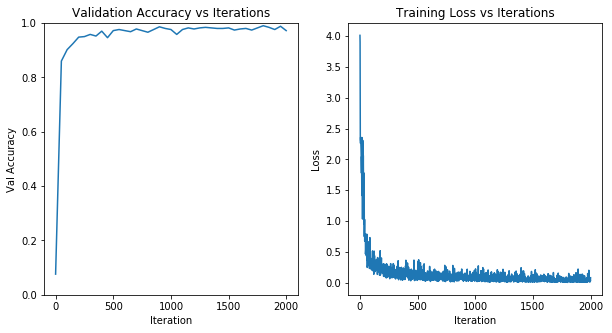

In [4]:
# Import data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)  
# Run train step
v_hist,v_iters,l_hist = train_step(p2_trainer, 2000, mnist.train, mnist.validation, mnist.test)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(v_iters, v_hist,label="Val Acc")
plt.title("Validation Accuracy vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Val Accuracy")
plt.ylim(0.,1.)

plt.subplot(1,2,2)
plt.plot(range(len(l_hist)),l_hist, label="Loss")
plt.title("Training Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

### Problem 2b - Calculate the receptive field of your 2-layer CNN for a 28x28 MNIST image.

$r_0=1, s_0=1$

- conv: $r_{out} = 1 + (3-1)*1 = 3; s_{prev}=1*1=1$

- conv: $r_{out} = 3 + (3-1)*1 = 5; s_{prev}=1*1=1$

$r_{out} = 5$ 

## Problem 3: Adding pooling and dropout to a 2-layer CNN with TensorFlow (24 points)

### Problem 3a - CNN with Pooling

- adding 2x2 pooling layers after each convolutional layer

#### Build Model

In [5]:
# Clear previous ops from the graph
tf.reset_default_graph()

# Build Network with 2 conv layers, a max pool layer after each conv, 
#   and 2 fc layers with 10-class output

#### Initialize Placeholders for inputs
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
y_ = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32) # Just here so I can use same trainer function. NOT used in this net

#### Initialize Learnable Parameters
# Conv-1
conv1_filter = tf.Variable(tf.truncated_normal([3,3,1,32], dtype=tf.float32, stddev=1e-1))
conv1_bias = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32), trainable=True)
# Conv-2
conv2_filter = tf.Variable(tf.truncated_normal([3,3,32,64], dtype=tf.float32, stddev=1e-1))
conv2_bias = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32), trainable=True)
# FC-1
fc1_W = tf.Variable(tf.truncated_normal([7*7*64, 512], dtype=tf.float32, stddev=1e-1))
fc1_b = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True)
# FC-2
fc2_W = tf.Variable(tf.truncated_normal([512, 10], dtype=tf.float32, stddev=1e-1))
fc2_b = tf.Variable(tf.constant(0.0, shape=[10], dtype=tf.float32), trainable=True)

#### Build Forward Pass
# Conv-1
c1 = tf.nn.conv2d(x, conv1_filter, [1,1,1,1], padding="SAME") # out = 28x28x32
b1 = tf.nn.bias_add(c1, conv1_bias)
conv1 = tf.nn.relu(b1)
conv1_pool = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') # out = 14x14x32
print("Conv1.shape: {0}".format(conv1.shape))
print("Conv1_pool.shape: {0}".format(conv1_pool.shape))
# Conv-2
c2 = tf.nn.conv2d(conv1_pool, conv2_filter, [1,1,1,1], padding="SAME") # out = 14x14x64
b2 = tf.nn.bias_add(c2, conv2_bias)
conv2 = tf.nn.relu(b2)
conv2_pool = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') # out = 7x7x64
print("Conv2.shape: {0}".format(conv2.shape))
print("Conv2_pool.shape: {0}".format(conv2_pool.shape))
# FC-1
flat = tf.reshape(conv2_pool, [-1,7*7*64])
f1 = tf.matmul(flat, fc1_W) + fc1_b
fc1 = tf.nn.relu(f1)
print("fc1.shape: {0}".format(fc1.shape))
# FC-2
f2 = tf.matmul(fc1, fc2_W) + fc2_b
y_logits = f2
print("y_logits.shape: {0}".format(y_logits.shape))

# Define accuracy operation for validation step
correct_preds = tf.equal(tf.argmax(y_logits,1),tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

# Define Cross Entropy Loss Function and SGD Optimizer
xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logits))
p3a_trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(xent)

Conv1.shape: (?, 28, 28, 32)
Conv1_pool.shape: (?, 14, 14, 32)
Conv2.shape: (?, 14, 14, 64)
Conv2_pool.shape: (?, 7, 7, 64)
fc1.shape: (?, 512)
y_logits.shape: (?, 10)


#### Run Model

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
[ 0 / 2000 ] Validation Accuracy: 0.14000000171363353
[ 50 / 2000 ] Validation Accuracy: 0.9079999804496766
[ 100 / 2000 ] Validation Accuracy: 0.9459999918937685
[ 150 / 2000 ] Validation Accuracy: 0.952000004053116
[ 200 / 2000 ] Validation Accuracy: 0.971999990940094
[ 250 / 2000 ] Validation Accuracy: 0.9679999887943267
[ 300 / 2000 ] Validation Accuracy: 0.9699999988079073
[ 350 / 2000 ] Validation Accuracy: 0.9800000071525572
[ 400 / 2000 ] Validation Accuracy: 0.9700000047683714
[ 450 / 2000 ] Validation Accuracy: 0.9639999985694885
[ 500 / 2000 ] Validation Accuracy: 0.9820000052452088
[ 550 / 2000 ] Validation Accuracy: 0.9860000014305115
[ 600 / 2000 ] Validation Accuracy: 0.9820000052452087
[ 650 / 2000 ] Validation Accuracy: 0.980000001192093
[ 700 / 2000 ] Validation Acc

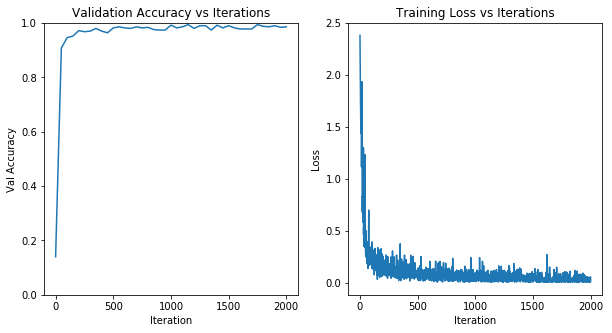

In [6]:
# Import data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)  
# Run train step
v_hist,v_iters,l_hist = train_step(p3a_trainer, 2000, mnist.train, mnist.validation, mnist.test)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(v_iters, v_hist,label="Val Acc")
plt.title("Validation Accuracy vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Val Accuracy")
plt.ylim(0.,1.)

plt.subplot(1,2,2)
plt.plot(range(len(l_hist)),l_hist, label="Loss")
plt.title("Training Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

### Problem 3b - CNN with Dropout

- Probability of dropout during training=50%

#### Build Model

In [7]:
# Clear previous ops from the graph
tf.reset_default_graph()

# Build Network with 2 conv layers and 2 fc layers with 10-class output and dropout

#### Initialize Placeholders for inputs
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
y_ = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32) # Actually used here

#### Initialize Learnable Parameters
# Conv-1
conv1_filter = tf.Variable(tf.truncated_normal([3,3,1,32], dtype=tf.float32, stddev=1e-1))
conv1_bias = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32), trainable=True)
# Conv-2
conv2_filter = tf.Variable(tf.truncated_normal([3,3,32,64], dtype=tf.float32, stddev=1e-1))
conv2_bias = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32), trainable=True)
# FC-1
fc1_W = tf.Variable(tf.truncated_normal([28*28*64, 512], dtype=tf.float32, stddev=1e-1))
fc1_b = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True)
# FC-2
fc2_W = tf.Variable(tf.truncated_normal([512, 10], dtype=tf.float32, stddev=1e-1))
fc2_b = tf.Variable(tf.constant(0.0, shape=[10], dtype=tf.float32), trainable=True)

#### Build Forward Pass
# Conv-1
c1 = tf.nn.conv2d(x, conv1_filter, [1,1,1,1], padding="SAME") # out = 28x28x32
b1 = tf.nn.bias_add(c1, conv1_bias)
conv1 = tf.nn.relu(b1)
print("Conv1.shape: {0}".format(conv1.shape))
# Conv-2
c2 = tf.nn.conv2d(conv1, conv2_filter, [1,1,1,1], padding="SAME") # out = 28x28x64
b2 = tf.nn.bias_add(c2, conv2_bias)
conv2 = tf.nn.relu(b2)
print("Conv2.shape: {0}".format(conv2.shape))
# FC-1
flat = tf.reshape(conv2, [-1,28*28*64])
f1 = tf.matmul(flat, fc1_W) + fc1_b
fc1 = tf.nn.relu(f1)
print("fc1.shape: {0}".format(fc1.shape))
fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob)
# FC-2
f2 = tf.matmul(fc1_drop, fc2_W) + fc2_b
y_logits = f2
print("y_logits.shape: {0}".format(y_logits.shape))

# Define accuracy operation for validation step
correct_preds = tf.equal(tf.argmax(y_logits,1),tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

# Define Cross Entropy Loss Function and SGD Optimizer
xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logits))
p3b_trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(xent)

Conv1.shape: (?, 28, 28, 32)
Conv2.shape: (?, 28, 28, 64)
fc1.shape: (?, 512)
y_logits.shape: (?, 10)


#### Run Training

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
[ 0 / 2000 ] Validation Accuracy: 0.09399999864399433
[ 50 / 2000 ] Validation Accuracy: 0.8159999966621401
[ 100 / 2000 ] Validation Accuracy: 0.9000000000000001
[ 150 / 2000 ] Validation Accuracy: 0.92399999499321
[ 200 / 2000 ] Validation Accuracy: 0.9279999911785126
[ 250 / 2000 ] Validation Accuracy: 0.9480000078678132
[ 300 / 2000 ] Validation Accuracy: 0.9420000076293946
[ 350 / 2000 ] Validation Accuracy: 0.9519999980926515
[ 400 / 2000 ] Validation Accuracy: 0.957999986410141
[ 450 / 2000 ] Validation Accuracy: 0.9699999988079071
[ 500 / 2000 ] Validation Accuracy: 0.9619999945163726
[ 550 / 2000 ] Validation Accuracy: 0.9540000021457673
[ 600 / 2000 ] Validation Accuracy: 0.9679999947547914
[ 650 / 2000 ] Validation Accuracy: 0.9739999949932099
[ 700 / 2000 ] Validation Acc

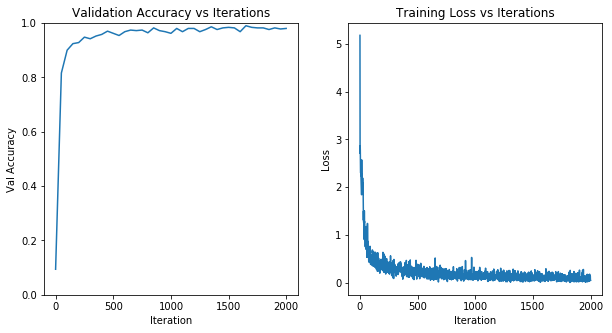

In [8]:
# Import data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)  
# Run train step
v_hist,v_iters,l_hist = train_step(p3b_trainer, 2000, mnist.train, mnist.validation, mnist.test)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(v_iters, v_hist,label="Val Acc")
plt.title("Validation Accuracy vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Val Accuracy")
plt.ylim(0.,1.)

plt.subplot(1,2,2)
plt.plot(range(len(l_hist)),l_hist, label="Loss")
plt.title("Training Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

## Problem 4: Performance comparison (24 points)

The goal is to compare the performance characteristics of different architectures at classifying
MNIST digits. For this purpose, split the data into training and validation using the standard
60K/10K split. Please answer the following questions:

    a) What is the validation accuracy of the CNN with and without pooling?
    b) Did you observe any performance improvements after adding dropout?
    c) How does the CNN model compare, in terms of performance, to the multi-class logistic regression and multi-class MLP from HW2?
    d) How does the number of trainable parameters in the CNN models compare to that of the multi-class logistic regression and multi-class MLP from HW2?
    
Notes:
- All CNN models trained for 2000 iterations using SGD with fixed learning rate of 0.1 to minimize cross entropy loss.
- Dropout model used 50% probability of dropout during training

**(A)** What is the validation accuracy of the CNN with and without pooling?

For the CNN without pooling (problem 2), the best observed validation accuracy over 500 random samples from the validation set is 99%. After training, the final model achieved 98.24% on the full test set. For the CNN with pooling (problem 3a), the best observed validation accuracy was 99.4% and the final model tested at 98.76%. Overall, both models performed very similarly with the pooling version slightly outperforming the non-pooling version. One noticeable improvement with the pooling version was training was much faster, as the pooling operators significantly decreased the spatial sizes of the feature maps.

**(B)** Did you observe any performance improvements after adding dropout?

No, I did not notice performance benefits with dropout. The non-dropout model had a final test accuracy of 98.24% and the dropout model yielded 98.03%, which is a negligible difference. Also, the learning curves for the two models appear about the same.

**(C)** How does the CNN model compare, in terms of performance, to the multi-class logistic regression and multi-class MLP from HW2 (HW1?) ?

All of the models tested here performed better than the logistic regression and MLP models from HW2. The logistic regression model had a final test accuracy of 89.7% and the 2-Layer MLP with 100 nodes in each hidden layer tested at 93.69%. Thus, the CNN models here all significantly outperformed those at about 98% accuracy.

**(D)** How does the number of trainable parameters in the CNN models compare to that of the multi-class logistic regression and multi-class MLP from HW2?

Logistic Regression:
- W = 784x10 = 7,840
- b = 10
- TOTAL = 7,850

100-100 node MLP
- W1 = 784x100 = 78,400
- b1 = 100
- W2 = 100x100 = 10,000
- b2 = 100
- W3 = 100x10 = 1,000
- b3 = 10
- TOTAL = 89,610

CNN - vanilla and with dropout
- Conv1-K = 3x3x1x32 = 288
- Conv1-b = 32
- Conv2-K = 3x3x32x64 = 18,432
- Conv2-b = 64
- W1 = 28x28x64x512 = 25,690,112
- b1 = 512
- W2 = 512x10 = 5,120
- b2 = 10
- TOTAL = 25,714,570

CNN - with pooling
- Conv1-K = 3x3x1x32 = 288
- Conv1-b = 32
- Conv2-K = 3x3x32x64 = 18,432
- Conv2-b = 64
- W1 = 7x7x64x512 = 1,605,632
- b1 = 512
- W2 = 512x10 = 5,120
- b2 = 10
- TOTAL = 1,630,090

Overall, the number of trainable parameters in the CNN models is significantly more than the logistic regression and MLP models. However, the convolutional layers play a very small part in the total. The dominant factor in the total is the first FC layer of the CNN which takes the flattened feature map from the second conv layer. We can also see that pooling has a large impact on parameters. The pooling operator does not add additional params, but significantly decreased the number of parameters in the feature map, meaning the flattened feature vector is much smaller after the second conv layer. Suprisingly, the CNN with pooling has over 15x less parameters but still outperforms the bigger models.

## Problem 5: Bookkeeping (4 points)

**(A)** 

This assignment took 10-15 hours

**(B)**

I adhered to the Duke Community Standard in the completion of this assignment - NAI